# Recommendation System, with Matrix Factorisation techniques and Neural Network, to personalize photo recommendation for user

Social media platforms produce a huge volume of semi-structured data. This provides a valuable and rich source of data to be analysed, which can potentially output insightful information about users and products. Companies can make use of this to further optimize their business.

In this project, I have semi-structured data in the form of social media photos. I will attempt to create a personalized recommendation system to recommend a list of photos to each user.

The information regarding the datasets used for this project is as follows:

- Train data: The training dataset contains a set of interactions between users and items (photos). If a user liked a photo (e.g., click the "heart" emoji which indicates a positive engagement), then there will be a record in the dataset.
- Test data: Each user is provided with a list of 100 candidate photos in the test dataset. I will need to check the candidate list and recommend the top 15 photos for each user.
- Validation data: A validation dataset that I will use to tune my models. The dataset format is similar to the Test dataset, except that the ground truth of the rating is given.
- User feature data: Each user is represented as a 256-dimensional feature representation, which is the average of the image feature representations they liked in the training data.
- Item feature data: Each photo is represented as a 256-dimensional embedding which is extracted from a pre-training deep learning framework.
- Links data: If two users are friends, there will be a link between two users.

## Table of Content
1. [Exploratory Data Analysis](#1)
2. [Recommendation System Models](#2)
    - 2.1 [Alternating Least Square (ALS)](#2.1)
    - 2.2 [Matrix Factorisation with Bias](#2.2)
3. [Comparision and Discussion](#3)

In [45]:
#Import libraries
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import implicit
import scipy.sparse as sparse
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ndcg_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# 1. Exploratory Data Analysis <a class="anchor" id="1"></a>

In [2]:
#Load data
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
val=pd.read_csv('validation.csv')
user_fea=pd.read_csv('user_fea.csv')
item_fea=pd.read_csv('item_fea.csv')
links=pd.read_csv('links.csv')

## Train data

In [3]:
train.head()

,user_id,item_id,rating
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110129 entries, 0 to 110128
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  110129 non-null  int64
 1   item_id  110129 non-null  int64
 2   rating   110129 non-null  int64
dtypes: int64(3)
memory usage: 2.5 MB


In [8]:
train.nunique()

user_id    3466
item_id    9004
rating        1
dtype: int64

In [9]:
train.isnull().sum()  #no missing values

user_id    0
item_id    0
rating     0
dtype: int64

In [10]:
train['rating'].value_counts()

1    110129
Name: rating, dtype: int64

## Validation data

In [11]:
val.head()

,user_id,item_id,rating
0,0,20,1
1,0,3260,0
2,0,390,0
3,0,5425,0
4,0,8631,0


In [12]:
val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346600 entries, 0 to 346599
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  346600 non-null  int64
 1   item_id  346600 non-null  int64
 2   rating   346600 non-null  int64
dtypes: int64(3)
memory usage: 7.9 MB


In [13]:
val.nunique()

user_id    3466
item_id    9004
rating        2
dtype: int64

In [14]:
val.isnull().sum()

user_id    0
item_id    0
rating     0
dtype: int64

In [15]:
val['rating'].value_counts()  #only about 1% of labels in validation data is 1

0    343134
1      3466
Name: rating, dtype: int64

## Test data

In [16]:
test.head()

,user_id,item_id
0,0,8929
1,0,8906
2,0,8838
3,0,8821
4,0,8756


In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346600 entries, 0 to 346599
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  346600 non-null  int64
 1   item_id  346600 non-null  int64
dtypes: int64(2)
memory usage: 5.3 MB


In [18]:
test.nunique()

user_id    3466
item_id    9004
dtype: int64

In [19]:
test.isnull().sum()

user_id    0
item_id    0
dtype: int64

## User Feature data

In [20]:
user_fea.head()

,Unnamed: 0,fea_0,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,...,fea_246,fea_247,fea_248,fea_249,fea_250,fea_251,fea_252,fea_253,fea_254,fea_255
0,0,-1.238114,-1.020155,-1.370791,-1.892076,-1.615505,-1.056106,-1.260189,-1.537514,-1.279543,...,-1.639152,-1.351084,-1.526210,-1.441551,-1.567562,-1.363613,-1.133677,-1.448653,-1.912987,-1.220462
1,1,-1.142714,-1.012310,-1.109844,-1.806807,-1.533666,-0.894846,-1.360289,-1.159866,-1.184760,...,-1.471417,-1.028792,-1.397979,-1.304754,-1.630009,-1.318048,-1.080598,-1.251735,-1.813930,-0.975978
2,2,-1.698521,-1.605196,-1.328976,-1.492204,-1.541542,-1.155632,-1.297039,-1.485625,-1.348223,...,-1.529016,-1.372415,-1.769800,-1.414428,-1.550462,-1.249593,-1.284915,-1.446422,-1.686583,-1.145916
3,3,-1.328761,-1.267363,-1.243220,-1.721551,-1.182082,-1.320123,-1.115170,-1.122703,-1.140961,...,-1.441997,-0.956042,-1.570591,-1.238835,-1.489867,-1.320204,-1.202990,-1.322884,-1.580290,-0.931394
4,4,-1.132466,-1.026957,-1.019664,-1.649181,-1.382753,-0.776261,-1.221357,-1.061034,-1.041313,...,-1.307160,-0.940088,-1.313026,-1.308773,-1.455208,-1.056440,-0.950118,-1.029165,-1.593675,-0.886145


In [22]:
user_fea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3466 entries, 0 to 3465
Columns: 257 entries, Unnamed: 0 to fea_255
dtypes: float64(256), int64(1)
memory usage: 6.8 MB


In [23]:
user_fea.nunique()

Unnamed: 0    3466
fea_0         3466
fea_1         3466
fea_2         3466
fea_3         3466
              ... 
fea_251       3466
fea_252       3466
fea_253       3466
fea_254       3466
fea_255       3466
Length: 257, dtype: int64

In [25]:
#Check if all columns are not null
user_fea.notnull().all().all()

True

## Item Feature data

In [26]:
item_fea.head()

,Unnamed: 0,fea_0,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,...,fea_246,fea_247,fea_248,fea_249,fea_250,fea_251,fea_252,fea_253,fea_254,fea_255
0,0,-1.360416,-0.683295,-0.659030,-1.840172,-1.875868,0.369852,-0.806902,-0.210944,-1.371679,...,-1.287771,-0.003345,-1.017979,-0.849153,-1.564582,-1.167882,-1.138140,-0.459417,-1.342706,-0.491899
1,1,-5.414928,-4.034106,-6.748904,-4.867840,-8.706087,-8.195160,-5.521785,-5.785634,-6.909437,...,-6.531560,-8.419637,-9.145112,-4.200750,-7.780539,-4.257525,-5.879356,-8.006350,-9.809999,-8.942007
2,2,-0.742383,-0.772285,-0.565367,-1.349759,-0.456425,-0.973115,-1.273366,-0.878384,-0.554383,...,-1.065703,-0.614035,-0.517165,-0.655323,-1.019581,-1.706855,-1.084116,-0.940970,-0.905574,-1.151560
3,3,-0.853681,-1.021450,-0.639012,-2.095687,-1.756671,-0.450270,-0.607497,-0.755120,-0.827463,...,-1.223609,-1.181383,-0.928340,-0.841091,-1.477898,-1.802510,-1.177191,-1.632113,-1.980912,-1.298478
4,4,-1.049173,-0.208819,-1.020380,-1.916308,-1.213041,0.404414,-1.085374,-1.219756,-0.854078,...,-1.427951,-0.035228,-0.856884,-1.142188,-1.742321,-0.767455,0.114727,-0.083121,-1.886625,-0.243228


In [27]:
item_fea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9004 entries, 0 to 9003
Columns: 257 entries, Unnamed: 0 to fea_255
dtypes: float64(256), int64(1)
memory usage: 17.7 MB


In [28]:
item_fea.nunique()

Unnamed: 0    9004
fea_0         9004
fea_1         9004
fea_2         9004
fea_3         9004
              ... 
fea_251       9004
fea_252       9004
fea_253       9004
fea_254       9004
fea_255       9004
Length: 257, dtype: int64

In [30]:
#Check if all columns are not null
item_fea.notnull().all().all()

True

## Links data

In [31]:
links.head()

,src,des,weight
0,0,1431,1
1,0,955,1
2,0,1824,1
3,0,70,1
4,0,592,1


In [32]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63994 entries, 0 to 63993
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   src     63994 non-null  int64
 1   des     63994 non-null  int64
 2   weight  63994 non-null  int64
dtypes: int64(3)
memory usage: 1.5 MB


In [33]:
links.nunique()

src       3452
des       3336
weight       1
dtype: int64

In [34]:
links.isnull().sum()

src       0
des       0
weight    0
dtype: int64

In [35]:
links['weight'].value_counts()

1    63994
Name: weight, dtype: int64

As the links represent social network connection, we can build a network graph to better visualize this Link dataset

In [39]:
#Build empty graph
G_links = nx.empty_graph()

#Iterate over dataframe and add nodes-edges
for index, row in links.iterrows():
    G_links.add_edge(row["src"], row["des"])

In [40]:
#Prepare lists of nodes, edges and degrees
G_links_nodes = list(G_links.nodes())
G_links_edges = list(G_links.edges())
G_links_degree = list(G_links.degree())
G_links_degrees_all_list = list(dict(G_links_degree).values())

#Count of nodes and edges
count_nodes_links = len(G_links_nodes)
count_edges_links = len(G_links_edges)

#Calculate average, median, min, and max of degrees
avg_degree_links = np.mean(G_links_degrees_all_list)
med_degree_links = np.median(G_links_degrees_all_list)
max_degree_links = np.max(G_links_degrees_all_list)
min_degree_links = np.min(G_links_degrees_all_list)

print ("Number of nodes: " + str(count_nodes_links))
print ("Number of edges: " + str(count_edges_links))

print ("Maximum degree: " + str(max_degree_links))
print ("Minimum degree: " + str(min_degree_links))

print ("Average degree: " + str(np.round(avg_degree_links,3)))
print ("Median degree: " + str(np.round(med_degree_links,3)))

Number of nodes: 3465
Number of edges: 60551
Maximum degree: 421
Minimum degree: 1
Average degree: 34.95
Median degree: 27.0


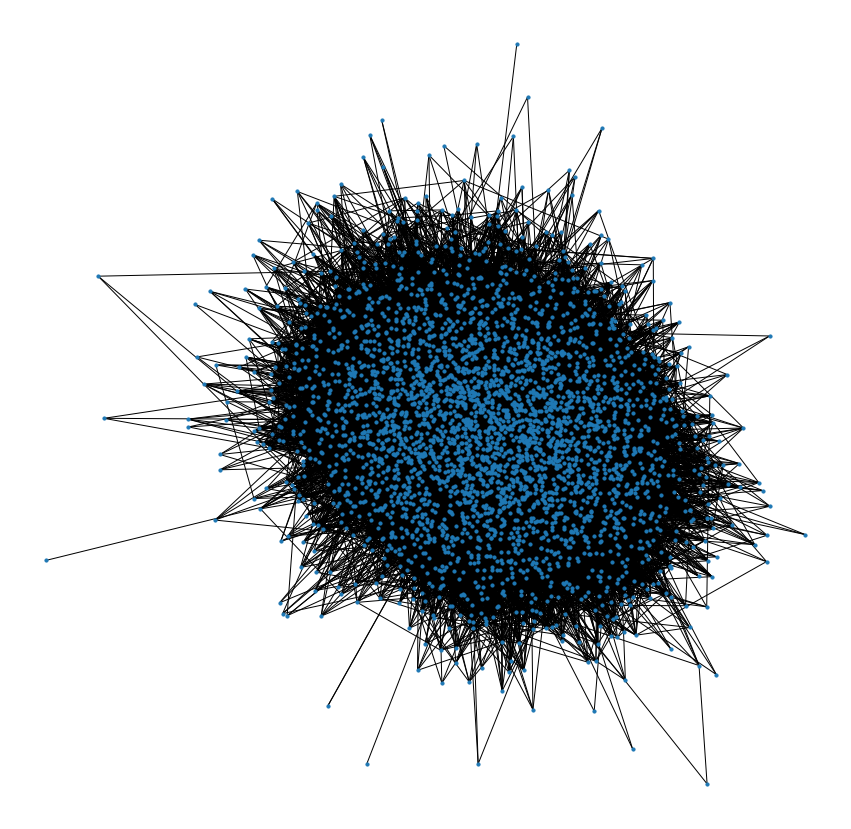

In [46]:
#Visualise social network data
with sns.axes_style('white'):
    fig = plt.subplots(1, figsize=(15,15))
    nx.draw_networkx(G_links, edge_color='black', node_size=10, with_labels=False, arrows=False)
    plt.axis('off')

## Summary of EDA findings

* There are 3466 unique users and 9004 unique items in the train, validation, and test datasets.
* Train, validation, and test datasets include 110129, 346600, and 346600 entries, respectively.
* There is no `null` value in any of the datasets.
* Rating column in train dataset contains only `1` rating, indicating positive implicit feedback. The column does not contain `0` values (which indicate uninteracted values).
* Rating column in validation dataset contains 1% `1` and 99% `0` values.
* User feature dataset contains 256 feature value for each of 3466 users.
* Item feature dataset contains 256 feature value for each of 9004 items.
* Links dataset contains 63994 entries. There are 3452 unique values in `src` column, while 3336 in `des` column. 
* Links dataset can be represented as a network graph. It contains 3465 nodes and 60551 edges.

## Data Preparation

In [47]:
#Lists and counts of all unique users and items
#List of all unique users
all_users = train["user_id"].unique().tolist()
#List of all unique items
all_items = train["item_id"].unique().tolist()

#Count of all unique users
num_users = train["user_id"].nunique()
#Count of all unique items
num_items = train["item_id"].nunique()

Next, a dictionary is prepared which contains users as keys and interacted items for each user as lists. This is done separately for train, validation, and test datasets. For the train dataset, only interacted items are available. However, for the validation and test, each of the lists with 100 items represent candidate for that user.

In [48]:
#Dict of all items that has been interacted with by each user
user_interacted_items = train.groupby('user_id')['item_id'].apply(list).to_dict()

#Dict of all 100 items that are candidated for each user
user_100_val_items = val.groupby('user_id')['item_id'].apply(list).to_dict()
user_100_test_items = test.groupby('user_id')['item_id'].apply(list).to_dict()

Next, all pairs of (user, item) in each dataset are prepared as a separate set. Note that in the train dataset, only items WITH interaction are available (rating = 1).

In [49]:
#The set of (user, item) that each user had interaction with (train data)
train_user_item_set = set(zip(train['user_id'], train['item_id']))

#The set of (user, item) in the validation dataset
val_user_item_set = set(zip(val['user_id'], val['item_id']))

#The set of (user, item) in the test dataset
test_user_item_set = set(zip(test['user_id'], test['item_id']))

# 2. Recommendation System Models <a class="anchor" id="2"></a>

## 2.1 Alternating Least Square (ALS) <a class="anchor" id="2.1"></a>

In this section, I will attempt to build Alternating Least Square (ALS) model and perform recommendations.

ALS is a form of matrix factorization that reduces the user-item matrix to a space with fewer dimensions. These dimensions are called *latent* or *hidden* features and they are learnt them from data.

In [50]:
#Define a function to get the score of an item for an user
min_max=MinMaxScaler()
def recommend(person_id,sparse_person_content,person_vecs,content_vecs,item_id):
    #Get interaction scores from the sparse user item matrix
    person_interactions=sparse_person_content[person_id,:].toarray()
    
    #add 1 to everything, so item with no interaction yet become equal to 1
    person_interactions=person_interactions.reshape(-1)+1
    
    #Make items already interacted 0
    person_interactions[person_interactions>1]=0
    
    #get dotproduct of person vector and all content vectors
    rec_vector=person_vecs[person_id,:].dot(content_vecs.T).toarray()
    
    #Scale this recommendation vector between 0 and 1
    rec_vector_scaled=min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    
    #Content already interacted have their recommendation multiplied by zero
    recommend_vector=person_interactions*rec_vector_scaled
    
    #Get the score for the item of that user
    score=recommend_vector[item_id]
    return score

In [51]:
#Convert to sparse matrices
sparse_item_user=sparse.csr_matrix((train['rating'],(train['item_id'],train['user_id'])))
sparse_user_item=sparse.csr_matrix((train['rating'],(train['user_id'],train['item_id'])))

Next, we will tune various hyperparameters, using NDCG score as the evaluation metrics. 

In [53]:
#For 15 items for each user in the validation set
valid_15=val.groupby('user_id').head(15).reset_index(drop=True)

#create 'position' column to assume the position of items recommended in the validation set
valid_15['position']=valid_15.groupby('user_id').cumcount(ascending=False).add(1)
valid_15

,user_id,item_id,rating,position
0,0,20,1,15
1,0,3260,0,14
2,0,390,0,13
3,0,5425,0,12
4,0,8631,0,11
...,...,...,...,...
51985,3465,8620,0,5
51986,3465,2970,0,4
51987,3465,2173,0,3
51988,3465,3960,0,2


In [55]:
#Create a dataframe to store the ndcg score of each configuration of the hyperparameters so we can compare them later
df_cv=pd.DataFrame(columns=['alpha','factor','regularization','iterations','NDCG'])

##tuning hypeparameters with NDCG metrics
#alpha hyperparameter
for alp in range(15,31,5):
    #factors hyperparameter
    for factor in range(10,41,10):
        #regularization hyperparameter
        for reg in np.arange(0.2,0.5,0.05):
            #iterations hyperparameters
            for ite in range(50,110,10):
                data=(sparse_item_user*alp).astype('double')
                als=implicit.als.AlternatingLeastSquares(factors=factor,regularization=reg,iterations=ite)
                als.fit(data)
                person_vecs=sparse.csr_matrix(als.user_factors)
                content_vecs=sparse.csr_matrix(als.item_factors)
                
                #work on a copy of validation data
                valid_cv=valid_15.copy()
                
                #Create a list to store all the score of items for all users in the validation data
                pred_list=[]
                
                for user in range(num_users):
                    #Get interaction scores from the sparse user item matrix
                    person_interactions=sparse_user_item[user,:].toarray()
                    
                    #Add 1 to everything, so item with no iteraction yet become 1
                    person_interactions=person_interactions.reshape(-1)+1
                    
                    #Make items already interacted 0
                    person_interactions[person_interactions>1]=0
                    
                    #get dotproduct of person vector and all content vectors
                    rec_vector=person_vecs[user,:].dot(content_vecs.T).toarray()
                    
                    #Scale this recommendation vector between 0 and 1
                    rec_vector_scaled=min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
                    
                    #Content already interacted have their recommendation multiplied by zero
                    recommend_vector=person_interactions*rec_vector_scaled
                    
                    #Get the list of scores of all the items in the candidate list for a user, in the validation set
                    prediction=[recommend_vector[i] for i in valid_cv.loc[valid_cv.user_id==user,'item_id']]
                    pred_list=pred_list+prediction
                    
                #get ndcg on the valid_15      
                ndcg=ndcg_score(np.array([valid_15['position']]),np.array([pred_list]))
                
                #Store the information of this configuration of model in df_cv
                df_cv.loc[len(df_cv)]=[alp,factor,reg,ite,ndcg]

In [56]:
df_cv

,alpha,factor,regularization,iterations,NDCG
0,15.0,10.0,0.20,50.0,0.954641
1,15.0,10.0,0.20,60.0,0.954891
2,15.0,10.0,0.20,70.0,0.954664
3,15.0,10.0,0.20,80.0,0.954742
4,15.0,10.0,0.20,90.0,0.954758
...,...,...,...,...,...
571,30.0,40.0,0.45,60.0,0.953597
572,30.0,40.0,0.45,70.0,0.953779
573,30.0,40.0,0.45,80.0,0.953684
574,30.0,40.0,0.45,90.0,0.953422


In [57]:
#Get the best combination of hyperparameters, that results in the highest NDCG score 
best_hyperparam_ndcg=df_cv[df_cv.NDCG==max(df_cv.NDCG)]
best_hyperparam_ndcg

,alpha,factor,regularization,iterations,NDCG
293,25.0,10.0,0.2,100.0,0.955374


In [58]:
#train the ALS again with this combination
sparse_item_user=sparse.csr_matrix((train['rating'],
                                   (train['item_id'],train['user_id'])))
sparse_user_item=sparse.csr_matrix((train['rating'],
                                   (train['user_id'],train['item_id'])))
#Use the best alpha
data=(sparse_item_user*best_hyperparam_ndcg.iloc[0]['alpha']).astype('double')

#Use the best factor,regularization and iteration
als=implicit.als.AlternatingLeastSquares(factors=best_hyperparam_ndcg.iloc[0]['factor'].astype('int'),
                                regularization=best_hyperparam_ndcg.iloc[0]['regularization'].astype('int'),
                                iterations=best_hyperparam_ndcg.iloc[0]['iterations'].astype('int')) 

als.fit(data)

In [60]:
test_als=test
#get the trained person and content vectors,convert them to csr matrices
person_vecs=sparse.csr_matrix(als.user_factors)
content_vecs=sparse.csr_matrix(als.item_factors)

#Get the score for each item in the candidate list for each user
test_als['score']=test_als.apply(lambda x:recommend(x['user_id'],sparse_user_item,
                                                              person_vecs,content_vecs,x['item_id']),axis=1)

#Sort user_id in ascending order, and within each user, sort score in descending order
#For each user, get the top 15 item based on score
test_als=test_als.sort_values(by=['user_id','score'],ascending=[True,False]).groupby('user_id').head(15)
test_als=test_als.drop(columns=['score'])
test_als

,user_id,item_id
18,0,7128
85,0,1267
31,0,6343
58,0,3450
19,0,7091
...,...,...
346596,3465,163
346551,3465,3889
346593,3465,454
346525,3465,6728


In [62]:
#output to csv file
test_als.to_csv('test_als.csv',index=False)

This `test_als` gives a NDCG score of 0.22267 on the test set on Kaggle

## 2.2 Matrix Factorisation with Bias <a class="anchor" id="2.2"></a>

# 3. Comparison and Discussion <a class="anchor" id="3"></a>

In [ ]:
__________